In [1]:
import sys
import os

import numpy as np
import matplotlib.pyplot as plt
import glob
import pandas as pd
import seaborn as sns

import scanpy as sc
import scanpy.external as sce
import anndata as ad

import session_info
import warnings
from pyprojroot.here import here

import scienceplots
from sklearn.neighbors import NearestNeighbors
from typing import Iterable
import pickle
from matplotlib.backends.backend_pdf import PdfPages


# Setting some parameters
warnings.filterwarnings("ignore")
sys.path.insert(1, str(here('bin')))

# Import custom functions
from customPythonFunctions import *

print("Main directory path: {}".format(here()))

plt.style.use(['nature'])
dpi_fig_save = 300
sc.set_figure_params(dpi=100, dpi_save=dpi_fig_save, vector_friendly=True)

Main directory path: /scratch_isilon/groups/singlecell/shared/projects/Inflammation-PBMCs-Atlas


**Setting parameters** 

In [2]:
overwriteFigures = True
overwriteData = True

In [3]:
cellGroup = 'T_CD8_NonNaive'
workDir = os.getcwd()

**Load data**

In [4]:
# Load the scvi h5ad file
adata = sc.read_h5ad(here("{}/results/03_{}_scVI_UMAP_clinical_allGenes.h5ad".format(workDir, cellGroup)))
adata.uns['log1p'] = dict()
adata.uns['log1p']['base'] = None # only if logscale is computed
adata

AnnData object with n_obs × n_vars = 824758 × 22838
    obs: 'studyID', 'libraryID', 'sampleID', 'chemistry', 'technology', 'patientID', 'disease', 'timepoint_replicate', 'treatmentStatus', 'therapyResponse', 'sex', 'age', 'BMI', 'binned_age', 'diseaseStatus', 'smokingStatus', 'ethnicity', 'institute', 'diseaseGroup', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'total_counts_plt', 'log1p_total_counts_plt', 'pct_counts_plt', 'doublet_score', 'predicted_doublet', 'S_score', 'G2M_score', 'phase'
    var: 'hgnc_id', 'symbol', 'locus_group', 'HUGO_status', 'mt', 'ribo', 'hb', 'plt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable'
    uns: '_scvi_

**Loading gene dictionary**

In [5]:
with open(here('external_reference_data/markerGenes_dictionary.pkl'), 'rb') as f:
    marker_genes_dict = pickle.load(f)

In [6]:
canonical_marker_gene_list = [g for g in marker_genes_dict['lineages'].values() for g in g if g in adata.var.symbol.values]

if cellGroup in marker_genes_dict:
    lineage_marker_gene_list = set([g for g in marker_genes_dict[cellGroup].values() for g in g if g in adata.var.symbol.values])
else: 
    lineage_marker_gene_list = None

**Plotting parameters** 

In [7]:
max_cells_plot = 200000
fraction = min(1, (max_cells_plot/adata.shape[0]))

**Loading clustering resolutions** 

In [8]:
clusterDF_path = here('{}/results/INFLAMMATION_clustering_resolutions_to_explore.pkl'.format(workDir))
clusterDF = pd.read_pickle(clusterDF_path)
clusterDF.head()

,leiden_res_0.1,leiden_res_0.25,leiden_res_0.5,leiden_res_0.75,leiden_res_1
cellID,,,,,
SCGT00_L051_I56.3P_T0_AACGGGAGTTAAGGAT,0,4,1,14,10
SCGT00_L051_I52.3P_T0_AACGTCAAGCCGAATG,0,2,3,7,16
SCGT00_L051_I52.3P_T0_ACAACCAAGCTGGTGA,0,2,3,3,14
SCGT00_L051_I53.3P_T0_ACATGCAGTGGACTGA,0,4,1,1,5
SCGT00_L051_I52.3P_T0_ACGATCACAGAGCTAG,0,4,11,14,17


In [9]:
# Merging cluster resolutions with adata object

adata_obs_df = adata.obs.merge(clusterDF, left_index=True, right_index=True, how='left')
adata.obs = adata_obs_df
adata.obs.head()

,studyID,libraryID,sampleID,chemistry,technology,patientID,disease,timepoint_replicate,treatmentStatus,therapyResponse,...,doublet_score,predicted_doublet,S_score,G2M_score,phase,leiden_res_0.1,leiden_res_0.25,leiden_res_0.5,leiden_res_0.75,leiden_res_1
cellID,,,,,,,,,,,,,,,,,,,,,
SCGT00_L051_I56.3P_T0_AACGGGAGTTAAGGAT,SCGT00,SCGT00_L051,SCGT00_I56.3P_T0,3_GEX_V3,3_GEX_V3_GenoHashed,SCGT00_I56,RA,0.0,ongoing,R,...,0.015,0,-0.073580,-0.073805,G1,0,4,1,14,10
SCGT00_L051_I52.3P_T0_AACGTCAAGCCGAATG,SCGT00,SCGT00_L051,SCGT00_I52.3P_T0,3_GEX_V3,3_GEX_V3_GenoHashed,SCGT00_I52,RA,0.0,ongoing,NR,...,0.008,0,-0.050342,-0.029862,G1,0,2,3,7,16
SCGT00_L051_I52.3P_T0_ACAACCAAGCTGGTGA,SCGT00,SCGT00_L051,SCGT00_I52.3P_T0,3_GEX_V3,3_GEX_V3_GenoHashed,SCGT00_I52,RA,0.0,ongoing,NR,...,0.085,0,-0.076014,-0.078051,G1,0,2,3,3,14
SCGT00_L051_I53.3P_T0_ACATGCAGTGGACTGA,SCGT00,SCGT00_L051,SCGT00_I53.3P_T0,3_GEX_V3,3_GEX_V3_GenoHashed,SCGT00_I53,RA,0.0,ongoing,R,...,0.080,0,-0.095771,-0.013405,G1,0,4,1,1,5
SCGT00_L051_I52.3P_T0_ACGATCACAGAGCTAG,SCGT00,SCGT00_L051,SCGT00_I52.3P_T0,3_GEX_V3,3_GEX_V3_GenoHashed,SCGT00_I52,RA,0.0,ongoing,NR,...,0.394,0,-0.030129,-0.046672,G1,0,4,11,14,17


# Cluster annotation

In [10]:
# Establishing the resolution of choice
resolution_of_choice = 0.5
leiden_cluster = "leiden_res_" + str(resolution_of_choice)
de_key = "de_res_" + str(resolution_of_choice)

### Subclustering

In [12]:
# Splitting cluster 2 into T_CD4_NonNaive and T_CD8_NonNaive
subcluster_leiden = 'leiden_res_{}_subcluster2'.format(resolution_of_choice)

adataSub = sc.pp.neighbors(adata[adata.obs[leiden_cluster] == '2'], n_neighbors = 10, n_pcs=adata.obsm['X_scVI'].shape[1], use_rep = 'X_scVI', copy = True)
sc.tl.leiden(adataSub, resolution = 0.2, key_added = subcluster_leiden, copy = False)
adataSub.obs[subcluster_leiden].value_counts()

leiden_res_0.5_subcluster2
0    70738
1    38136
Name: count, dtype: int64

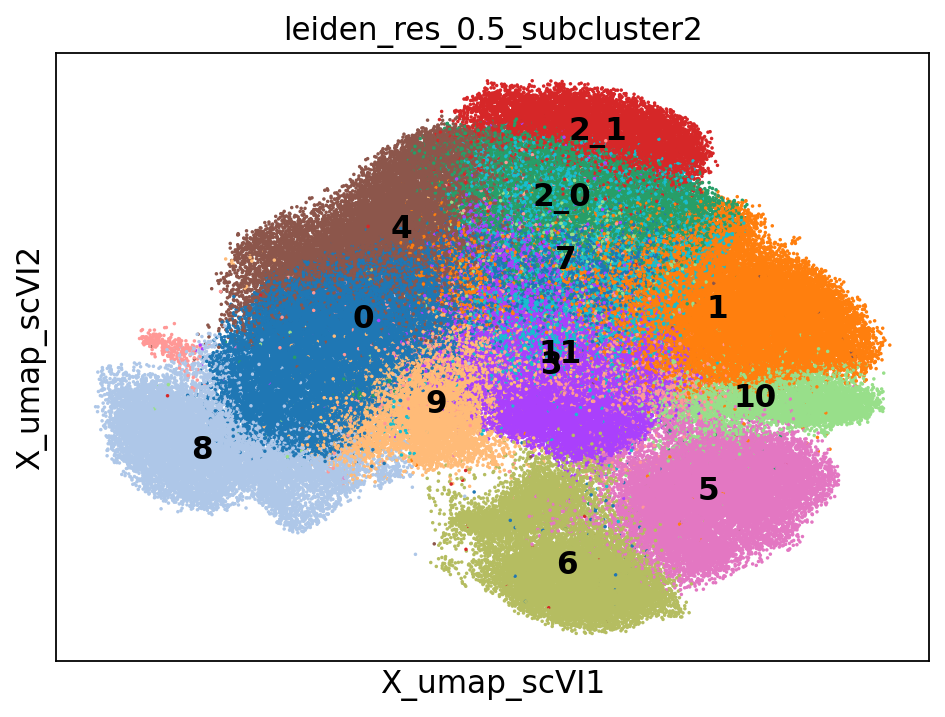

In [13]:
adata.obs[subcluster_leiden] = adata.obs[leiden_cluster].astype(str)
adataSub.obs[subcluster_leiden] = adataSub.obs[subcluster_leiden].astype(str)
adataSub.obs[subcluster_leiden] = "2_" + adataSub.obs[subcluster_leiden]
adata.obs.loc[adata.obs[subcluster_leiden] == "2", subcluster_leiden] = adataSub.obs[subcluster_leiden]

# Subsetting and randomizing for optimal plotting
random_indices = balanced_sample(adata.obs, cols = 'leiden_res_{}_subcluster2'.format(resolution_of_choice), frac = fraction, shuffle = True, random_state = 42).cellID
ID2SymbolDF = generateID2SymbolDF(varDF = adata[random_indices, :].var, symbolList = canonical_marker_gene_list, 
                                  ID_col = 'index', symbols_col = 'symbol', HUGOstatus_col = 'HUGO_status', behaviour = 'all')

sc.set_figure_params(figsize=(7, 5))
fig = sc.pl.embedding(adata[random_indices, :], basis="X_umap_scVI", color='leiden_res_{}_subcluster2'.format(resolution_of_choice), 
                      use_raw=False, show=True, return_fig=True, size=10, legend_loc="on data")

In [14]:
# Splitting cluster 8 into UTC and T_CD8_NonNaive
subcluster_leiden = 'leiden_res_{}_subcluster8'.format(resolution_of_choice)

adataSub = sc.pp.neighbors(adata[adata.obs[leiden_cluster] == '8'], n_neighbors = 10, n_pcs=adata.obsm['X_scVI'].shape[1], use_rep = 'X_scVI', copy = True)
sc.tl.leiden(adataSub, resolution = 0.1, key_added = subcluster_leiden, copy = False)
adataSub.obs[subcluster_leiden].value_counts()

leiden_res_0.5_subcluster8
0    42077
1     8020
Name: count, dtype: int64

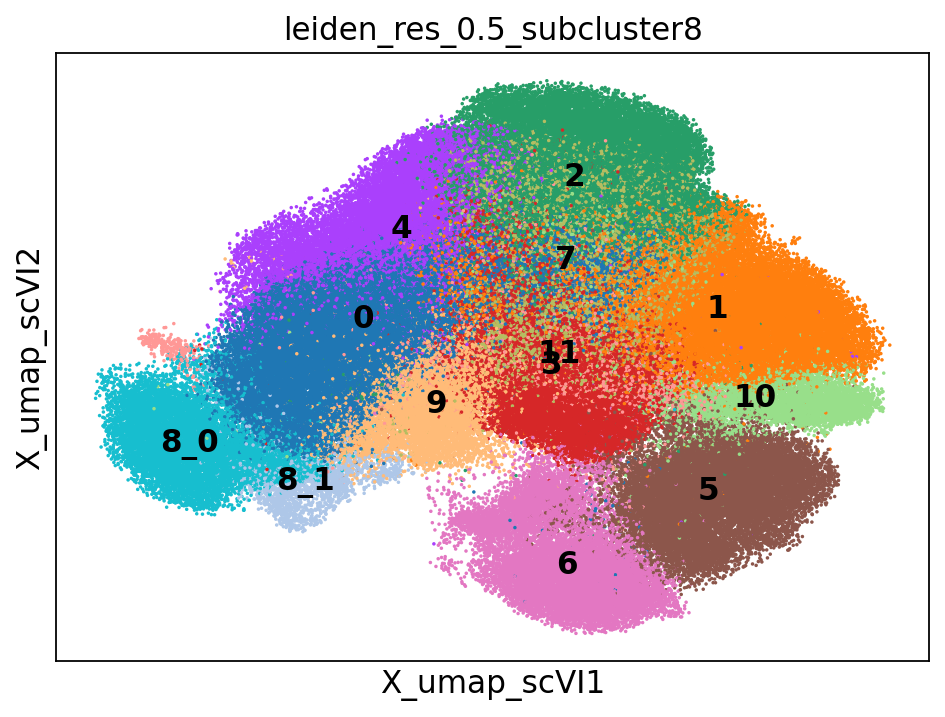

In [15]:
adata.obs[subcluster_leiden] = adata.obs[leiden_cluster].astype(str)
adataSub.obs[subcluster_leiden] = adataSub.obs[subcluster_leiden].astype(str)
adataSub.obs[subcluster_leiden] = "8_" + adataSub.obs[subcluster_leiden]
adata.obs.loc[adata.obs[subcluster_leiden] == "8", subcluster_leiden] = adataSub.obs[subcluster_leiden]

# Subsetting and randomizing for optimal plotting
random_indices = balanced_sample(adata.obs, cols = 'leiden_res_{}_subcluster8'.format(resolution_of_choice), frac = fraction, shuffle = True, random_state = 42).cellID
ID2SymbolDF = generateID2SymbolDF(varDF = adata[random_indices, :].var, symbolList = canonical_marker_gene_list, 
                                  ID_col = 'index', symbols_col = 'symbol', HUGOstatus_col = 'HUGO_status', behaviour = 'all')

sc.set_figure_params(figsize=(7, 5))
fig = sc.pl.embedding(adata[random_indices, :], basis="X_umap_scVI", color='leiden_res_{}_subcluster8'.format(resolution_of_choice), 
                      use_raw=False, show=True, return_fig=True, size=10, legend_loc="on data")

In [17]:
# Convert the main clustering column to categorical
adata.obs["leiden_res_0.5_subcluster"] = adata.obs["leiden_res_0.5"].astype('str')

# Replace values where the original value is "2" with values from "leiden_res_0.5_subcluster2"
adata.obs.loc[adata.obs["leiden_res_0.5_subcluster"] == "2", "leiden_res_0.5_subcluster"] = adata.obs.loc[adata.obs["leiden_res_0.5_subcluster"] == "2", "leiden_res_0.5_subcluster2"]

# Replace values where the original value is "8" with values from "leiden_res_0.5_subcluster8"
adata.obs.loc[adata.obs["leiden_res_0.5_subcluster"] == "8", "leiden_res_0.5_subcluster"] = adata.obs.loc[adata.obs["leiden_res_0.5_subcluster"] == "8", "leiden_res_0.5_subcluster8"]

# Convert the column back to categorical if needed
adata.obs["leiden_res_0.5_subcluster"] = adata.obs["leiden_res_0.5_subcluster"].astype('category')
adata.obs["leiden_res_0.5_subcluster"] 

cellID
SCGT00_L051_I56.3P_T0_AACGGGAGTTAAGGAT      1
SCGT00_L051_I52.3P_T0_AACGTCAAGCCGAATG      3
SCGT00_L051_I52.3P_T0_ACAACCAAGCTGGTGA      3
SCGT00_L051_I53.3P_T0_ACATGCAGTGGACTGA      1
SCGT00_L051_I52.3P_T0_ACGATCACAGAGCTAG     11
                                         ... 
Ren2021_L066_PS053_T0_TTTGTCACAGGCGATA      3
Ren2021_L066_PS053_T0_TTTGTCAGTATAGGTA      3
Ren2021_L066_PS053_T0_TTTGTCAGTCTAGCCG     11
Ren2021_L066_PS053_T0_TTTGTCAGTTCCGGCA      0
Ren2021_L066_PS053_T0_TTTGTCATCTTGCCGT    2_0
Name: leiden_res_0.5_subcluster, Length: 824758, dtype: category
Categories (14, object): ['0', '1', '10', '11', ..., '7', '8_0', '8_1', '9']

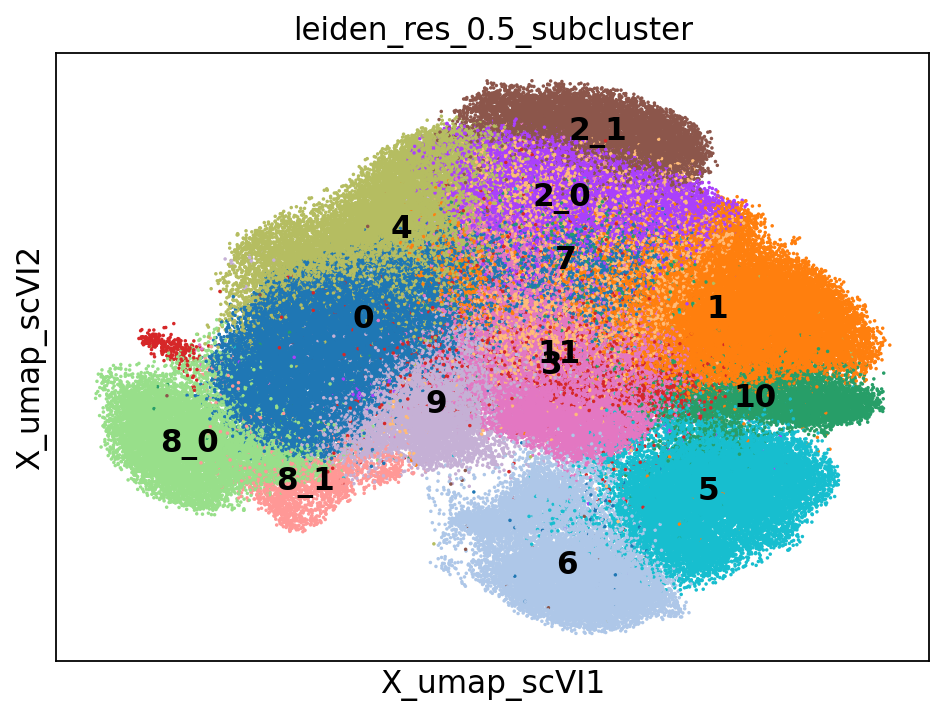

In [18]:
# Subsetting and randomizing for optimal plotting
random_indices = balanced_sample(adata.obs, cols = 'leiden_res_{}_subcluster'.format(resolution_of_choice), frac = fraction, shuffle = True, random_state = 42).cellID
ID2SymbolDF = generateID2SymbolDF(varDF = adata[random_indices, :].var, symbolList = canonical_marker_gene_list, 
                                  ID_col = 'index', symbols_col = 'symbol', HUGOstatus_col = 'HUGO_status', behaviour = 'all')

sc.set_figure_params(figsize=(7, 5))
fig = sc.pl.embedding(adata[random_indices, :], basis="X_umap_scVI", color='leiden_res_{}_subcluster'.format(resolution_of_choice), 
                      use_raw=False, show=True, return_fig=True, size=10, legend_loc="on data")

         Falling back to preprocessing with `sc.pp.pca` and default params.


NameError: name 'res' is not defined

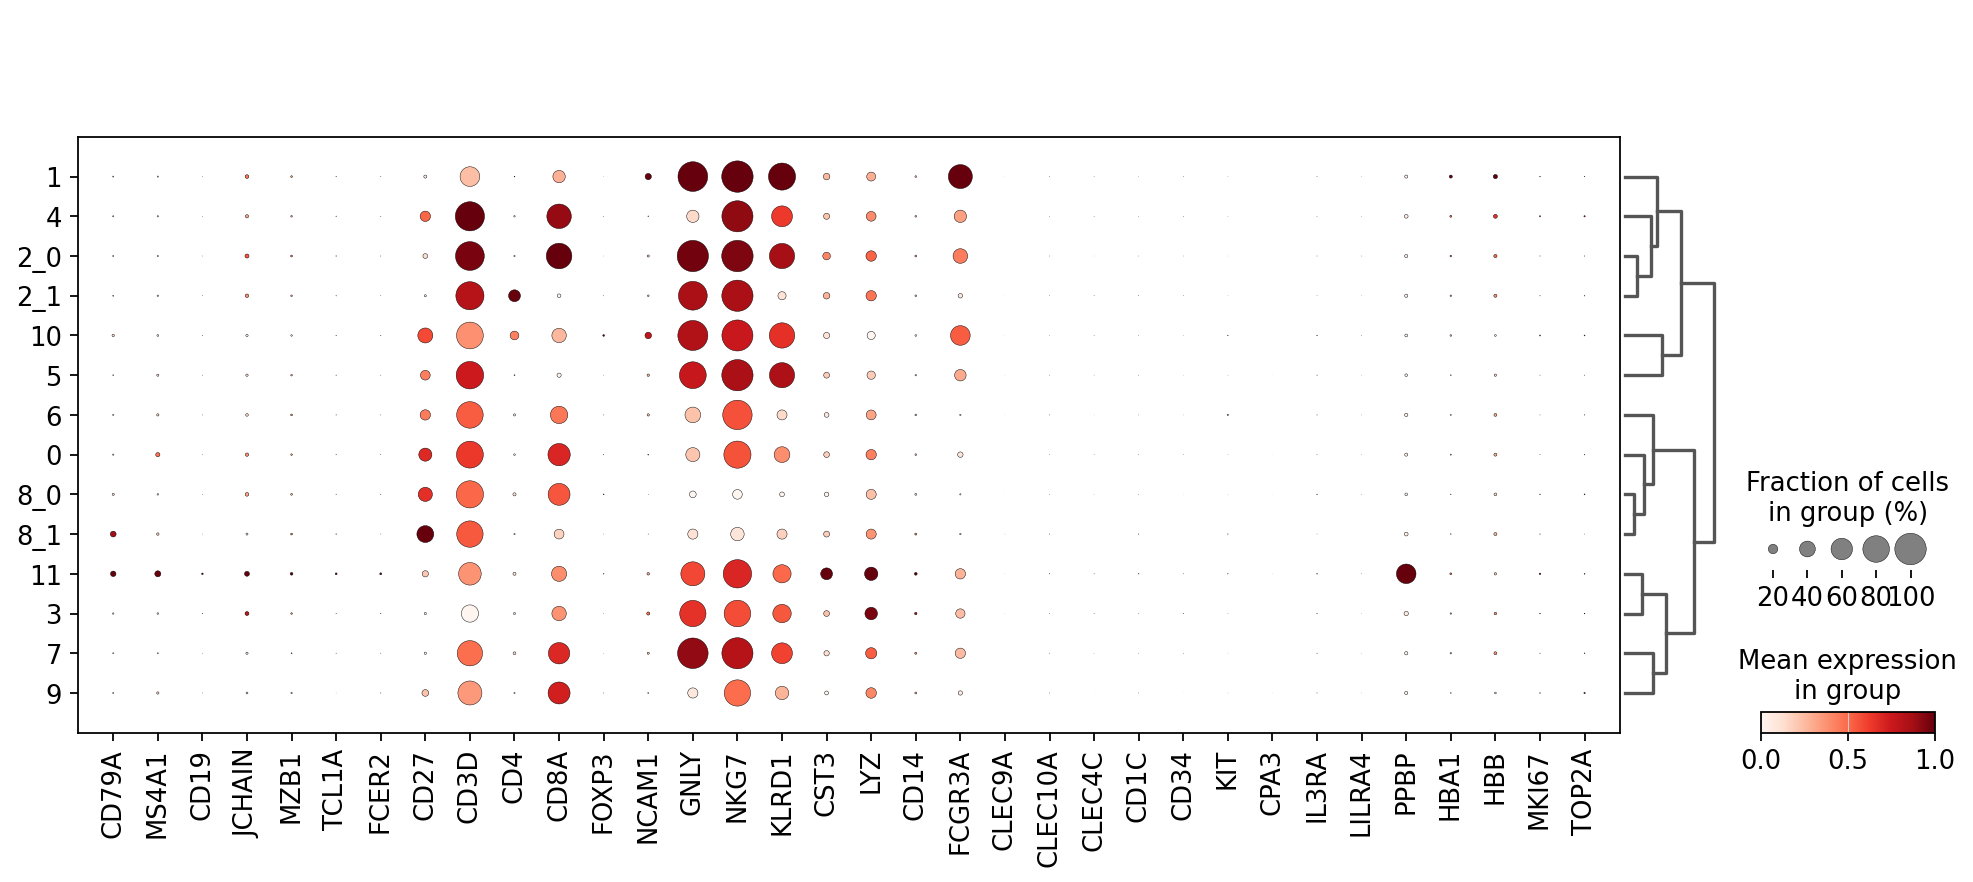

In [19]:
# Subsetting and randomizing for optimal plotting
random_indices = balanced_sample(adata.obs, cols = 'leiden_res_{}_subcluster'.format(resolution_of_choice), frac = fraction, shuffle = True, random_state = 42).cellID
ID2SymbolDF = generateID2SymbolDF(varDF = adata[random_indices, :].var, symbolList = canonical_marker_gene_list, 
                                  ID_col = 'index', symbols_col = 'symbol', HUGOstatus_col = 'HUGO_status', behaviour = 'all')

# Dotplot
sc.set_figure_params(figsize=(15, 7))
fig = sc.pl.dotplot(adata[random_indices, :],
                    var_names = ID2SymbolDF["gene_id"],
                    groupby='leiden_res_{}_subcluster'.format(resolution_of_choice), standard_scale='var', 
              use_raw = False, dendrogram=True, show=False, return_fig=False)
    # replace ensembls ids by gene symbol in plot
_ = fig['mainplot_ax'].set_xticklabels(ID2SymbolDF["symbol"])

if overwriteFigures:
    plt.savefig(here('{}/results/figures/Dotplot_CanonicalMarkers_res{}_subcluster.pdf'.format(workDir, res)), bbox_inches='tight', pad_inches=0, dpi=dpi_fig_save)

### Final annotation

In [22]:
# Dictionary to map cluster to annotation label
cluster2annotation_lineages = {
     '0': 'T_CD8_NonNaive',
     '1': 'T_CD8_NonNaive',
     '2_0': 'T_CD8_NonNaive', # split T_CD4_NonNaive and T_CD8_NonNaive
     '2_1': 'T_CD4_NonNaive', # split T_CD4_NonNaive and T_CD8_NonNaive
     '3': 'T_CD8_NonNaive',
     '4': 'T_CD8_NonNaive',
     '5': 'UTC', # gdT cells
     '6': 'UTC', # MAIT cells
     '7': 'T_CD8_NonNaive',
     '8_0': 'T_CD8_NonNaive', # split UTC and T_CD8_NonNaive
     '8_1': 'UTC', # split UTC and T_CD8_NonNaive
     '9': 'T_CD8_NonNaive',
     '10': 'T_CD8_NonNaive',
     '11': 'LowQuality_cells'
     # (...)
}

# Add a new `.obs` column called `annotation_column_name` by mapping clusters to annotation using pandas `map` function
#adata.obs[annotation_column_name] = adata.obs[leiden_cluster].map(cluster2annotation_lineages).astype('category')
annotation_column_name = "annotation_step_4"
adata.obs[annotation_column_name] = adata.obs['leiden_res_0.5_subcluster'].map(cluster2annotation_lineages).astype('category')

**Checking clustering annotation**

In [23]:
# List of all annotated cell types
print(set(adata.obs[annotation_column_name]))

# Confirm all cells got their assigment
if ("" in set(adata.obs[annotation_column_name])):
    print("Error: not all cells were assigned a lineage")
else:
    print("All cells were assigned a lineage!")

{'LowQuality_cells', 'T_CD8_NonNaive', 'UTC', 'T_CD4_NonNaive'}
All cells were assigned a lineage!


## Visualize annotation results

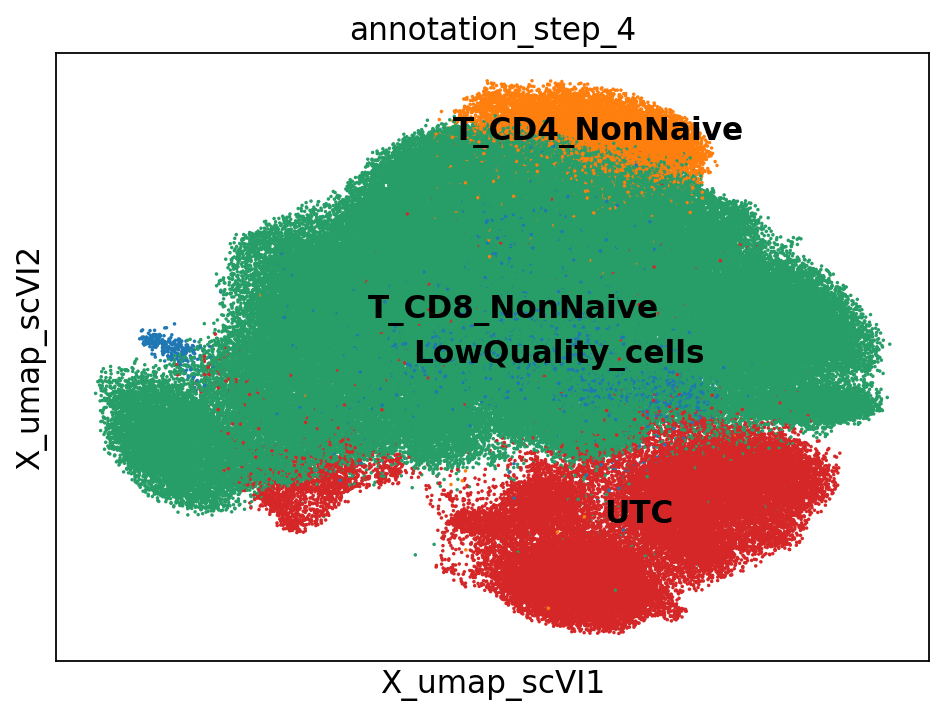

In [24]:
# Subsetting and randomizing for optimal plotting
random_indices = balanced_sample(adata.obs, cols = annotation_column_name, frac = fraction, shuffle = True, random_state = 42).cellID

sc.set_figure_params(figsize=(7, 5))
fig = sc.pl.embedding(adata[random_indices, :], basis="X_umap_scVI", color=annotation_column_name, 
                      use_raw=False, show=True, return_fig=True, size=10, legend_loc="on data")

if overwriteFigures:
    plt.savefig(here('{}/results/figures/UMAP_clusters_res{}_subcluster_annotated.pdf'.format(workDir, resolution_of_choice)), 
                bbox_inches='tight', pad_inches=0, dpi=dpi_fig_save)

## Export cluster annotation

In [25]:
clusterAnnotDF = pd.DataFrame(adata.obs[annotation_column_name])
# Save annotation as DF
clusterAnnotDF.to_pickle(path=here('{}/results/INFLAMMATION_cluster_res{}_annotated.pkl'.format(workDir, resolution_of_choice)))

In [26]:
session_info.show()